# Configuration and Training

In [2]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.utils.data import DataLoader, random_split
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision import models
import numpy as np
from tqdm import trange,tqdm
import matplotlib
import matplotlib.pyplot as plt


In [3]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.ids = [file for file in listdir(imgs_dir)]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx)
        img_file = glob(self.imgs_dir + idx)
        # print(self.masks_dir + idx)

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        mask = mask.convert("L")
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        # mask = np.asarray(list(mask.getdata()))

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        super().__init__(imgs_dir, masks_dir, scale, mask_suffix='_mask')

In [4]:
dir_img = './Original/'
dir_mask = './Ground-Truth/'
img_scale = 1
batch_size= 5
val_percent = 0.1
lr = 0.000003
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [6]:

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)


## filter sizes

In [7]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=False):
        super(UNet, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale
        self.n_classes = n_classes
        # filters = [16, 32, 64, 128, 256]
        filters = [32, 64, 128, 256, 512]
        # filters = [64, 128, 256, 512, 1024]
        # # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)
        #
        self.outconv1 = nn.Conv2d(filters[0], 1, 3, padding=1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def dotProduct(self,seg,cls):
        B, N, H, W = seg.size()
        seg = seg.view(B, N, H * W)
        final = torch.einsum("ijk,ij->ijk", [seg, cls])
        final = final.view(B, N, H, W)
        return final
 
    def forward(self, inputs):
        # 1 1 260 348
        conv1 = self.conv1(inputs)  # 16*512*1024
        # 1 64 260 348
        maxpool1 = self.maxpool1(conv1)  # 16*256*512
        # 1 64 130 174
        conv2 = self.conv2(maxpool1)  # 32*256*512
        # 1 128 130 174
        maxpool2 = self.maxpool2(conv2)  # 32*128*256
        # 1 128 65 87
        conv3 = self.conv3(maxpool2)  # 64*128*256
        # 1 256 65 87
        maxpool3 = self.maxpool3(conv3)  # 64*64*128
        # 1 256 32 43
        conv4 = self.conv4(maxpool3)  # 128*64*128
        # 1 512 32 43
        maxpool4 = self.maxpool4(conv4)  # 128*32*64
        # 1 512 16 21
        center = self.center(maxpool4)  # 256*32*64
        # 1 1024 16 21

        up4 = self.up_concat4(center, conv4)  # 128*64*128
        # 1 512 32 42

        up3 = self.up_concat3(up4, conv3)  # 64*128*256
        up2 = self.up_concat2(up3, conv2)  # 32*256*512
        up1 = self.up_concat1(up2, conv1)  # 16*512*1024

        d1 = self.outconv1(up1)  # 256

        return F.sigmoid(d1)


In [8]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


In [9]:
class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)

In [10]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


In [11]:
def BCE_loss(pred,label):
    bce_loss = nn.BCELoss(size_average=True)
    bce_out = bce_loss(pred, label)
    # print("bce_loss:", bce_out.data.cpu().numpy())
    return bce_out

In [12]:
def _iou(pred, target, size_average = True):

    b = pred.shape[0]
    IoU = 0.0
    for i in range(0,b):
        #compute the IoU of the foreground
        Iand1 = torch.sum(target[i,:,:,:]*pred[i,:,:,:])
        Ior1 = torch.sum(target[i,:,:,:]) + torch.sum(pred[i,:,:,:])-Iand1
        IoU1 = Iand1/Ior1

        #IoU loss is (1-IoU1)
        IoU = IoU + (1-IoU1)

    return IoU/b


class IOU(torch.nn.Module):
    def __init__(self, size_average = True):
        super(IOU, self).__init__()
        self.size_average = size_average

    def forward(self, pred, target):

        return _iou(pred, target, self.size_average)

def IOU_loss(pred,label):
    iou_loss = IOU(size_average=True)
    iou_out = iou_loss(pred, label)
    print("iou_loss:", iou_out.data.cpu().numpy())
    return iou_out


In [13]:
!pip install torchsummary
from torchsummary import summary
net = UNet(in_channels=3, n_classes=1).to(device=device)
summary(net,input_size=(3,384,288), batch_size=1)

D:\ANACONDA\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1260.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
D:\ANACONDA\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 384, 288]             896
              ReLU-2          [1, 32, 384, 288]               0
            Conv2d-3          [1, 32, 384, 288]           9,248
              ReLU-4          [1, 32, 384, 288]               0
         unetConv2-5          [1, 32, 384, 288]               0
         MaxPool2d-6          [1, 32, 192, 144]               0
            Conv2d-7          [1, 64, 192, 144]          18,496
              ReLU-8          [1, 64, 192, 144]               0
            Conv2d-9          [1, 64, 192, 144]          36,928
             ReLU-10          [1, 64, 192, 144]               0
        unetConv2-11          [1, 64, 192, 144]               0
        MaxPool2d-12            [1, 64, 96, 72]               0
           Conv2d-13           [1, 128, 96, 72]          73,856
             ReLU-14           [1, 128,

## Unet model

In [14]:
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
for epoch in trange(epochs):
  epoch_loss = 0
  step = 0
  for batch in tqdm(train_loader):
    imgs = batch['image'].to(device=device)
    true_masks = batch['mask']
    true_masks = true_masks.to(device=device, dtype=torch.float32)
    masks_pred = net(imgs)
    # loss = IOU_loss(masks_pred,true_masks)
    loss = BCE_loss(masks_pred,true_masks)
    epoch_loss += loss.item()
    step += 1
    if step % 5 == 0:
      print(f'\nloss:{loss.item()} mean_loss:{epoch_loss/step}') 
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()
  torch.save(net.state_dict(), f'./result/U-net_lr{lr}_batch_size{batch_size}_epoch{epoch}.pth')

  0%|                                                                                          | 0/111 [00:00<?, ?it/s]D:\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

  4%|██▉                                                                               | 4/111 [00:00<00:20,  5.29it/s]


loss:0.6431822776794434 mean_loss:0.6982064127922059



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.72it/s]


loss:0.5572352409362793 mean_loss:0.6412558376789093



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.73it/s]


loss:0.5970958471298218 mean_loss:0.5988499959309895



 17%|█████████████▊                                                                   | 19/111 [00:03<00:17,  5.41it/s]


loss:0.3334127962589264 mean_loss:0.5614435568451881



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.63it/s]


loss:0.30379509925842285 mean_loss:0.5172318887710571



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.72it/s]


loss:0.29503387212753296 mean_loss:0.48732566138108574



 31%|████████████████████████▊                                                        | 34/111 [00:06<00:13,  5.75it/s]


loss:0.36372485756874084 mean_loss:0.4588611274957657



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.80it/s]


loss:0.2762274444103241 mean_loss:0.4385782353579998



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.80it/s]


loss:0.17322346568107605 mean_loss:0.41833690404891966



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.81it/s]


loss:0.2638166546821594 mean_loss:0.4056565707921982



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.82it/s]


loss:0.21535804867744446 mean_loss:0.3889781334183433



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:08,  5.82it/s]


loss:0.22077687084674835 mean_loss:0.37913847068945566



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.83it/s]


loss:0.29060477018356323 mean_loss:0.3750172028174767



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.80it/s]


loss:0.21169380843639374 mean_loss:0.3649746343493462



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.79it/s]


loss:0.25252997875213623 mean_loss:0.3592398230234782



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.80it/s]


loss:0.3038259446620941 mean_loss:0.3557312894612551



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.78it/s]


loss:0.33649370074272156 mean_loss:0.3512768911964753



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.78it/s]


loss:0.3452681601047516 mean_loss:0.3474920724829038



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.79it/s]


loss:0.39139899611473083 mean_loss:0.344756375959045



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.78it/s]


loss:0.21107901632785797 mean_loss:0.3396264272928238



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.77it/s]


loss:0.1309158354997635 mean_loss:0.3332381803364981



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:18<00:00,  5.80it/s]


loss:0.17686884105205536 mean_loss:0.3287834285335107



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.54it/s]


loss:0.17444774508476257 mean_loss:0.2201940894126892



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.90it/s]


loss:0.276582270860672 mean_loss:0.23787028342485428



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.82it/s]


loss:0.26284801959991455 mean_loss:0.2444557120402654



 17%|█████████████▊                                                                   | 19/111 [00:03<00:15,  5.76it/s]


loss:0.1929866373538971 mean_loss:0.23907698318362236



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.78it/s]


loss:0.22457468509674072 mean_loss:0.2390875792503357



 26%|█████████████████████▏                                                           | 29/111 [00:04<00:14,  5.79it/s]


loss:0.2468172311782837 mean_loss:0.24206261734167736



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.77it/s]


loss:0.3478354215621948 mean_loss:0.2430751783507211



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.77it/s]


loss:0.2342929244041443 mean_loss:0.24574197754263877



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.77it/s]


loss:0.1484641432762146 mean_loss:0.2438068194521798



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.80it/s]


loss:0.23903495073318481 mean_loss:0.24567465901374816



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.78it/s]


loss:0.18779952824115753 mean_loss:0.24093327224254607



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.77it/s]


loss:0.22854293882846832 mean_loss:0.24240759015083313



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.77it/s]


loss:0.28309696912765503 mean_loss:0.2468827192599957



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:11<00:07,  5.76it/s]


loss:0.1997392475605011 mean_loss:0.24559686460665295



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.77it/s]


loss:0.22539405524730682 mean_loss:0.24767529408137004



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.76it/s]


loss:0.27734968066215515 mean_loss:0.24955902229994537



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.80it/s]


loss:0.3346472680568695 mean_loss:0.2508236246950486



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.74it/s]


loss:0.31850665807724 mean_loss:0.25170180400212605



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.77it/s]


loss:0.3704409897327423 mean_loss:0.25315274533472565



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.78it/s]


loss:0.201803520321846 mean_loss:0.25207660675048826



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:17<00:01,  5.79it/s]


loss:0.12228590995073318 mean_loss:0.24930066189595632



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:18<00:00,  5.78it/s]


loss:0.1726120561361313 mean_loss:0.24825729991902004



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.51it/s]


loss:0.1659717708826065 mean_loss:0.2114157795906067



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.85it/s]


loss:0.2734580934047699 mean_loss:0.22944321632385253



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.76it/s]


loss:0.25399309396743774 mean_loss:0.23553500473499298



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.75it/s]


loss:0.19329982995986938 mean_loss:0.23134459108114241



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.74it/s]


loss:0.21212339401245117 mean_loss:0.23093308687210082



 26%|█████████████████████▏                                                           | 29/111 [00:04<00:14,  5.74it/s]


loss:0.2354026436805725 mean_loss:0.2337045242389043



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.71it/s]


loss:0.33957406878471375 mean_loss:0.23491113356181553



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.73it/s]


loss:0.2249678075313568 mean_loss:0.23767367713153362



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.75it/s]


loss:0.144412100315094 mean_loss:0.23582042819923824



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.72it/s]


loss:0.2280842363834381 mean_loss:0.2375956118106842



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.73it/s]


loss:0.17689891159534454 mean_loss:0.23274306627837094



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.73it/s]


loss:0.22918212413787842 mean_loss:0.23452576845884324



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.72it/s]


loss:0.2819962501525879 mean_loss:0.23893953194985024



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:11<00:07,  5.74it/s]


loss:0.18809862434864044 mean_loss:0.23796483086688178



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.74it/s]


loss:0.2197057455778122 mean_loss:0.240292675892512



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.72it/s]


loss:0.2673780620098114 mean_loss:0.24196268077939748



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.73it/s]


loss:0.3334764838218689 mean_loss:0.24347116105696734



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.73it/s]


loss:0.3111874759197235 mean_loss:0.24430259747637642



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.71it/s]


loss:0.35956645011901855 mean_loss:0.24572282982499977



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.74it/s]


loss:0.19681644439697266 mean_loss:0.24467626363039016



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.71it/s]


loss:0.11630130559206009 mean_loss:0.24187705098163514



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:18<00:00,  5.73it/s]


loss:0.16700279712677002 mean_loss:0.240918086536906



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.46it/s]


loss:0.16196566820144653 mean_loss:0.20634854435920716



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.83it/s]


loss:0.27037477493286133 mean_loss:0.22413066774606705



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.76it/s]


loss:0.24778687953948975 mean_loss:0.229517862200737



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.73it/s]


loss:0.19026502966880798 mean_loss:0.22567623481154442



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.72it/s]


loss:0.20368117094039917 mean_loss:0.2250182557106018



 26%|█████████████████████▏                                                           | 29/111 [00:04<00:14,  5.74it/s]


loss:0.22636312246322632 mean_loss:0.2274962067604065



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.74it/s]


loss:0.3337576687335968 mean_loss:0.22868094316550663



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.74it/s]


loss:0.21714456379413605 mean_loss:0.231797094643116



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.73it/s]


loss:0.14644621312618256 mean_loss:0.22994255854023826



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.72it/s]


loss:0.21919886767864227 mean_loss:0.23159429371356965



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.73it/s]


loss:0.1643826812505722 mean_loss:0.22633120092478665



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.73it/s]


loss:0.22722506523132324 mean_loss:0.22825941716631254



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.73it/s]


loss:0.27643463015556335 mean_loss:0.23225045548035547



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:11<00:07,  5.74it/s]


loss:0.15976522862911224 mean_loss:0.23079058357647486



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.73it/s]


loss:0.21042415499687195 mean_loss:0.2337874166170756



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.73it/s]


loss:0.26089200377464294 mean_loss:0.23503092676401138



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.73it/s]


loss:0.3404989540576935 mean_loss:0.23677652741179747



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.73it/s]


loss:0.3158680498600006 mean_loss:0.23752243916193644



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.72it/s]


loss:0.34536221623420715 mean_loss:0.23891906079493072



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.56it/s]


loss:0.19518841803073883 mean_loss:0.23801992684602738



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.34it/s]


loss:0.11354765295982361 mean_loss:0.23523772188595363



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.32it/s]


loss:0.1603226363658905 mean_loss:0.2342335439541123



  4%|██▉                                                                               | 4/111 [00:00<00:17,  6.21it/s]


loss:0.15301592648029327 mean_loss:0.19939719140529633



  8%|██████▋                                                                           | 9/111 [00:01<00:18,  5.58it/s]


loss:0.2693202495574951 mean_loss:0.21837881803512574



 13%|██████████▏                                                                      | 14/111 [00:02<00:17,  5.46it/s]


loss:0.24010758101940155 mean_loss:0.22289589941501617



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.43it/s]


loss:0.1881304234266281 mean_loss:0.22002963498234748



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.64it/s]


loss:0.19657309353351593 mean_loss:0.2190078592300415



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.57it/s]


loss:0.2197919338941574 mean_loss:0.22153917302687962



 31%|████████████████████████▊                                                        | 34/111 [00:06<00:13,  5.64it/s]


loss:0.3265116214752197 mean_loss:0.22271620120321



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.70it/s]


loss:0.21284817159175873 mean_loss:0.2264782041311264



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.72it/s]


loss:0.1482391059398651 mean_loss:0.22474523352252113



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.69it/s]


loss:0.2102407068014145 mean_loss:0.2262152060866356



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:10,  5.68it/s]


loss:0.15555383265018463 mean_loss:0.2207429660992189



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.71it/s]


loss:0.22602522373199463 mean_loss:0.22259113018711407



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.71it/s]


loss:0.2677229940891266 mean_loss:0.22632334324029776



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.69it/s]


loss:0.1452421098947525 mean_loss:0.224565238399165



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:13<00:06,  5.70it/s]


loss:0.20560197532176971 mean_loss:0.22779588063557943



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.71it/s]


loss:0.2510637044906616 mean_loss:0.22883613575249911



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.71it/s]


loss:0.3534862995147705 mean_loss:0.23086651248090406



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.72it/s]


loss:0.31066301465034485 mean_loss:0.23154472096098794



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.67it/s]


loss:0.33763977885246277 mean_loss:0.23295715310071644



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.70it/s]


loss:0.18909427523612976 mean_loss:0.23210627242922782



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.71it/s]


loss:0.11139024794101715 mean_loss:0.22936974451655434



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.70it/s]


loss:0.1564670205116272 mean_loss:0.22829842310060156



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.44it/s]


loss:0.14151351153850555 mean_loss:0.19218910336494446



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.81it/s]


loss:0.26806899905204773 mean_loss:0.21255988180637359



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.72it/s]


loss:0.23651954531669617 mean_loss:0.21696198383967083



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.68it/s]


loss:0.1846543699502945 mean_loss:0.21503637582063675



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.70it/s]


loss:0.19093531370162964 mean_loss:0.21386972188949585



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.70it/s]


loss:0.2147321254014969 mean_loss:0.2164125695824623



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.70it/s]


loss:0.3222404718399048 mean_loss:0.21749788671731948



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.71it/s]


loss:0.20997871458530426 mean_loss:0.22166531961411237



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.69it/s]


loss:0.14912380278110504 mean_loss:0.22003187321954304



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.68it/s]


loss:0.2018403261899948 mean_loss:0.22131623223423957



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:10,  5.69it/s]


loss:0.14863981306552887 mean_loss:0.2157265304164453



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.70it/s]


loss:0.22514568269252777 mean_loss:0.21752169442673525



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.70it/s]


loss:0.2583593726158142 mean_loss:0.22089829937769817



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.68it/s]


loss:0.1394844353199005 mean_loss:0.21901137669171605



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.69it/s]


loss:0.20067693293094635 mean_loss:0.22235292543967564



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.68it/s]


loss:0.240844264626503 mean_loss:0.2231299110688269



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.69it/s]


loss:0.35520797967910767 mean_loss:0.22528377008788725



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.71it/s]


loss:0.3047283887863159 mean_loss:0.22598615777161385



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:03,  5.64it/s]


loss:0.3287610411643982 mean_loss:0.22745762302687295



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.69it/s]


loss:0.17594513297080994 mean_loss:0.22658931903541088



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.65it/s]


loss:0.10701460391283035 mean_loss:0.2238295370624179



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.66it/s]


loss:0.15729305148124695 mean_loss:0.22273551293394783



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.47it/s]


loss:0.1299814134836197 mean_loss:0.18655482530593873



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.82it/s]


loss:0.2647096514701843 mean_loss:0.2075273796916008



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.72it/s]


loss:0.23251605033874512 mean_loss:0.21196398735046387



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.69it/s]


loss:0.17978662252426147 mean_loss:0.21055579632520677



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.69it/s]


loss:0.18484725058078766 mean_loss:0.20931881695985793



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.69it/s]


loss:0.208598792552948 mean_loss:0.21148487851023673



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.70it/s]


loss:0.3196755349636078 mean_loss:0.2123693355492183



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.67it/s]


loss:0.20759613811969757 mean_loss:0.2168576281517744



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.69it/s]


loss:0.14693722128868103 mean_loss:0.21529266304439967



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.70it/s]


loss:0.1930486410856247 mean_loss:0.2163461199402809



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.70it/s]


loss:0.14210732281208038 mean_loss:0.2106929895552722



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.70it/s]


loss:0.22456011176109314 mean_loss:0.21242814560731252



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.71it/s]


loss:0.25150367617607117 mean_loss:0.21548684652035052



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.68it/s]


loss:0.13455329835414886 mean_loss:0.21367695395435607



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.69it/s]


loss:0.19413137435913086 mean_loss:0.2169863090912501



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.67it/s]


loss:0.2341611385345459 mean_loss:0.21761380843818187



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.69it/s]


loss:0.3502752184867859 mean_loss:0.21984152723761166



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.69it/s]


loss:0.295798122882843 mean_loss:0.2205105983548694



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:03,  5.57it/s]


loss:0.321603387594223 mean_loss:0.22212386052859456



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.33it/s]


loss:0.16256678104400635 mean_loss:0.22116928383708



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.29it/s]


loss:0.10491325706243515 mean_loss:0.21843100367557436



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.59it/s]


loss:0.15655028820037842 mean_loss:0.21724942915818907



  4%|██▉                                                                               | 4/111 [00:00<00:17,  6.20it/s]


loss:0.11977235227823257 mean_loss:0.18039412349462508



  8%|██████▋                                                                           | 9/111 [00:01<00:18,  5.59it/s]


loss:0.2525825798511505 mean_loss:0.2020776726305485



 13%|██████████▏                                                                      | 14/111 [00:02<00:17,  5.64it/s]


loss:0.22759336233139038 mean_loss:0.20695359657208126



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.52it/s]


loss:0.17316119372844696 mean_loss:0.20567356906831263



 22%|█████████████████▌                                                               | 24/111 [00:04<00:16,  5.37it/s]


loss:0.18022421002388 mean_loss:0.20469384908676147



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.49it/s]


loss:0.20201817154884338 mean_loss:0.20653320252895355



 31%|████████████████████████▊                                                        | 34/111 [00:06<00:14,  5.40it/s]


loss:0.3223940432071686 mean_loss:0.20720549587692533



 35%|████████████████████████████▍                                                    | 39/111 [00:07<00:12,  5.61it/s]


loss:0.2053668349981308 mean_loss:0.21180621590465307



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:12,  5.48it/s]


loss:0.14314386248588562 mean_loss:0.21027622537480462



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.65it/s]


loss:0.18545542657375336 mean_loss:0.21121310517191888



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:09,  5.70it/s]


loss:0.1364246904850006 mean_loss:0.2056156501173973



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.67it/s]


loss:0.2250499427318573 mean_loss:0.2072480438898007



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.68it/s]


loss:0.24333585798740387 mean_loss:0.21003352850675583



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.69it/s]


loss:0.12971213459968567 mean_loss:0.2084013829273837



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:13<00:06,  5.69it/s]


loss:0.1853218525648117 mean_loss:0.2116244074702263



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:14<00:05,  5.67it/s]


loss:0.22629314661026 mean_loss:0.21202632514759898



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:15<00:04,  5.69it/s]


loss:0.35257747769355774 mean_loss:0.21436674866606206



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.69it/s]


loss:0.2815588116645813 mean_loss:0.21505354386236933



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.68it/s]


loss:0.3141719102859497 mean_loss:0.21688865729068454



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.70it/s]


loss:0.1509968489408493 mean_loss:0.21587766535580158



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.70it/s]


loss:0.1043190285563469 mean_loss:0.2131205263591948



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.68it/s]


loss:0.15278133749961853 mean_loss:0.21183232881806113



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.46it/s]


loss:0.11285954713821411 mean_loss:0.1744101107120514



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.81it/s]


loss:0.23842892050743103 mean_loss:0.19585412442684175



 13%|██████████▏                                                                      | 14/111 [00:02<00:17,  5.68it/s]


loss:0.22108380496501923 mean_loss:0.20161370436350504



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.70it/s]


loss:0.16726623475551605 mean_loss:0.20067558325827123



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.68it/s]


loss:0.17746832966804504 mean_loss:0.20000312030315398



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.70it/s]


loss:0.19396227598190308 mean_loss:0.20154406130313873



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.68it/s]


loss:0.32354751229286194 mean_loss:0.20203350037336348



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.68it/s]


loss:0.20224450528621674 mean_loss:0.20667232628911733



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.67it/s]


loss:0.1387660950422287 mean_loss:0.20509400218725204



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.69it/s]


loss:0.17783573269844055 mean_loss:0.20590850010514258



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:10,  5.70it/s]


loss:0.1309678554534912 mean_loss:0.20043420534242284



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.68it/s]


loss:0.22442573308944702 mean_loss:0.20199301155904928



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.69it/s]


loss:0.23634479939937592 mean_loss:0.20455751659778448



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.67it/s]


loss:0.1258995532989502 mean_loss:0.20314544088074138



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.68it/s]


loss:0.1780143827199936 mean_loss:0.20626110901435216



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.70it/s]


loss:0.21653403341770172 mean_loss:0.20649594077840447



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.69it/s]


loss:0.3558940589427948 mean_loss:0.2090255650527337



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.68it/s]


loss:0.27612486481666565 mean_loss:0.20976473564902942



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.69it/s]


loss:0.3073982000350952 mean_loss:0.2117830954884228



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.70it/s]


loss:0.14659608900547028 mean_loss:0.2108179809898138



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.68it/s]


loss:0.10436125099658966 mean_loss:0.20811132753179187



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.70it/s]


loss:0.14829103648662567 mean_loss:0.20683773017742418



  4%|██▉                                                                               | 4/111 [00:00<00:16,  6.42it/s]


loss:0.10879766196012497 mean_loss:0.17060010582208635



  8%|██████▋                                                                           | 9/111 [00:01<00:17,  5.78it/s]


loss:0.2312919795513153 mean_loss:0.19156766757369043



 13%|██████████▏                                                                      | 14/111 [00:02<00:16,  5.71it/s]


loss:0.21646620333194733 mean_loss:0.19765882045030594



 17%|█████████████▊                                                                   | 19/111 [00:03<00:16,  5.70it/s]


loss:0.16337068378925323 mean_loss:0.19706060253083707



 22%|█████████████████▌                                                               | 24/111 [00:04<00:15,  5.69it/s]


loss:0.17572540044784546 mean_loss:0.19621797859668733



 26%|█████████████████████▏                                                           | 29/111 [00:05<00:14,  5.70it/s]


loss:0.1874452531337738 mean_loss:0.1975277935465177



 31%|████████████████████████▊                                                        | 34/111 [00:05<00:13,  5.69it/s]


loss:0.3208217918872833 mean_loss:0.19797161987849643



 35%|████████████████████████████▍                                                    | 39/111 [00:06<00:12,  5.67it/s]


loss:0.19873453676700592 mean_loss:0.20274899378418923



 40%|████████████████████████████████                                                 | 44/111 [00:07<00:11,  5.67it/s]


loss:0.13773921132087708 mean_loss:0.20111398299535116



 44%|███████████████████████████████████▊                                             | 49/111 [00:08<00:10,  5.68it/s]


loss:0.17235468327999115 mean_loss:0.20176475405693053



 49%|███████████████████████████████████████▍                                         | 54/111 [00:09<00:10,  5.68it/s]


loss:0.1256609857082367 mean_loss:0.19634248424660075



 53%|███████████████████████████████████████████                                      | 59/111 [00:10<00:09,  5.68it/s]


loss:0.22218389809131622 mean_loss:0.19778632869323096



 58%|██████████████████████████████████████████████▋                                  | 64/111 [00:11<00:08,  5.66it/s]


loss:0.23180553317070007 mean_loss:0.2001543702987524



 62%|██████████████████████████████████████████████████▎                              | 69/111 [00:12<00:07,  5.66it/s]


loss:0.1204153373837471 mean_loss:0.19880385686244284



 67%|██████████████████████████████████████████████████████                           | 74/111 [00:12<00:06,  5.66it/s]


loss:0.17296142876148224 mean_loss:0.20175264447927474



 71%|█████████████████████████████████████████████████████████▋                       | 79/111 [00:13<00:05,  5.68it/s]


loss:0.20819291472434998 mean_loss:0.20188820222392678



 76%|█████████████████████████████████████████████████████████████▎                   | 84/111 [00:14<00:04,  5.67it/s]


loss:0.34990066289901733 mean_loss:0.2044443602947628



 80%|████████████████████████████████████████████████████████████████▉                | 89/111 [00:15<00:03,  5.65it/s]


loss:0.2721691131591797 mean_loss:0.20520897118581666



 85%|████████████████████████████████████████████████████████████████████▌            | 94/111 [00:16<00:02,  5.68it/s]


loss:0.3010658919811249 mean_loss:0.20736152129737953



 89%|████████████████████████████████████████████████████████████████████████▏        | 99/111 [00:17<00:02,  5.69it/s]


loss:0.1448907107114792 mean_loss:0.20647057242691516



 94%|██████████████████████████████████████████████████████████████████████████▉     | 104/111 [00:18<00:01,  5.65it/s]


loss:0.10442185401916504 mean_loss:0.2038602406779925



 98%|██████████████████████████████████████████████████████████████████████████████▌ | 109/111 [00:19<00:00,  5.68it/s]


loss:0.14430482685565948 mean_loss:0.20257761878046124



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.54s/it]


In [19]:
def dice_coeff(input, target):

    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

def Dice_loss(pred,label):
  dice_loss = DiceLoss()
  dice_out = dice_loss(pred,label)
  print("\ndice_loss",dice_out.data.cpu().numpy())
  return dice_out

In [20]:
"""Evaluation without the densecrf with the dice coefficient"""
net.eval()
n_val = len(val_loader)  # the number of batch
tot = 0
index=0
for batch in tqdm(val_loader):
# batch = next(iter(val_loader))
  imgs, true_masks = batch['image'], batch['mask']
  imgs = imgs.to(device=device, dtype=torch.float32)
  true_masks = true_masks.to(device=device, dtype=torch.float32)
  with torch.no_grad():
      mask_pred = net(imgs)
      pred = torch.sigmoid(mask_pred)
      # pred = (pred > 0.5).float()
      single_dice = dice_coeff(pred, true_masks).item()
      tot += single_dice
      index += 1
      print(f'\nsingle_dice:{single_dice} mean_dice:{tot/index}')




  0%|                                                                                           | 0/13 [00:00<?, ?it/s]


single_dice:0.7013657093048096 mean_dice:0.7013657093048096


  8%|██████▍                                                                            | 1/13 [00:00<00:01,  6.13it/s]


single_dice:0.7051810026168823 mean_dice:0.703273355960846

single_dice:0.5659105777740479 mean_dice:0.6574857632319132


 23%|███████████████████▏                                                               | 3/13 [00:00<00:01,  7.05it/s]


single_dice:0.6998278498649597 mean_dice:0.6680712848901749

single_dice:0.6974841952323914 mean_dice:0.6739538669586181


 38%|███████████████████████████████▉                                                   | 5/13 [00:00<00:01,  7.99it/s]


single_dice:0.6690410375595093 mean_dice:0.6731350620587667

single_dice:0.7217674255371094 mean_dice:0.6800825425556728


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:00<00:00,  8.89it/s]


single_dice:0.6156337261199951 mean_dice:0.6720264405012131

single_dice:0.7428674101829529 mean_dice:0.6798976593547397


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:00<00:00,  9.65it/s]


single_dice:0.7239883542060852 mean_dice:0.6843067288398743

single_dice:0.6604535579681396 mean_dice:0.6821382587606256


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:01<00:00, 10.26it/s]


single_dice:0.6842057108879089 mean_dice:0.6823105464378992

single_dice:0.7666724920272827 mean_dice:0.6887999268678519


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00, 11.88it/s]


In [21]:
pre_dir='./Present-src/'
pre_mask='./Present-mask/'
present_dataset = BasicDataset(pre_dir, pre_mask, img_scale)
present_loader = DataLoader(present_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)


# Load and present model

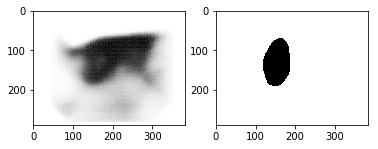

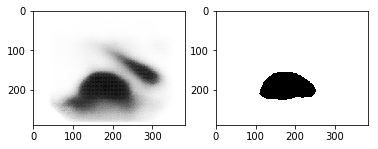

In [22]:
model_name ='U-net'
lr = 0.000003
batch_size = 5
epoch=10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, n_classes=1).to(device=device)
# model = torch.load(f'/content/drive/MyDrive/Dataset/CVC-ClinicDB/Result_models/{model_name}_lr{lr}_batch_size{batch_size}_epoch{epoch-1}.pth')
model.load_state_dict(torch.load(f'./result/{model_name}_lr{lr}_batch_size{batch_size}_epoch{epoch-2}.pth'))
model.eval()
for batch in present_loader:
  tmp,tmp_mask = batch['image'],batch['mask']
  # print(tmp.size)
  tmp = tmp.to(device=device, dtype=torch.float32)
  tmp_mask = tmp_mask.to(device=device, dtype=torch.float32)
  with torch.no_grad():
    mask_pred = model(tmp)
    pred = torch.sigmoid(mask_pred).cpu()
    tmp_mask=tmp_mask.cpu()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(pred[ :, :, :].squeeze(), cmap=plt.cm.gray_r)

    plt.subplot(1,2,2)
    plt.imshow(tmp_mask[ :, :, :].squeeze(), cmap=plt.cm.gray_r)
    plt.show()